# Predicting survivors of the Titanic Disaster with ML

In [1]:
# import libraries

import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# import datasets

df_train = pd.read_csv('data/train.csv', header = 0, dtype={'Age': np.float64})
df_test  = pd.read_csv('data/test.csv' , header = 0, dtype={'Age': np.float64})
df = df_train.append(df_test, ignore_index=True)


# Exploratory Analysis

In the image below there is a description of all the columns of the datasets

<img src='data/data_description.JPG'>

In [3]:
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
850,851,0.0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S
834,835,0.0,3,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S
992,993,NaN,2,"Weisz, Mr. Leopold",male,27.0,1,0,228414,26.0000,NaN,S
873,874,0.0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S
328,329,1.0,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S
385,386,0.0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5000,NaN,S
1199,1200,NaN,1,"Hays, Mr. Charles Melville",male,55.0,1,1,12749,93.5000,B69,S
930,931,NaN,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,NaN,S
514,515,0.0,3,"Coleff, Mr. Satio",male,24.0,0,0,349209,7.4958,NaN,S
93,94,0.0,3,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S


In [4]:
df_train.profile_report()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Visualization of survival rate

Visualizing the survival rate based on some features can help us to have a better understanding of which features influenced most the chance of survival

**Survival Rate based on Sex**

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

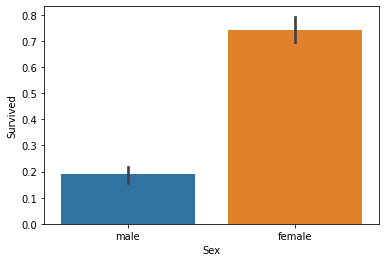

In [6]:
sns.barplot(x="Sex", y="Survived", data=df_train)

Female has a lot higher rate of survival.

**Survival Rate based on Ticket Class**

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

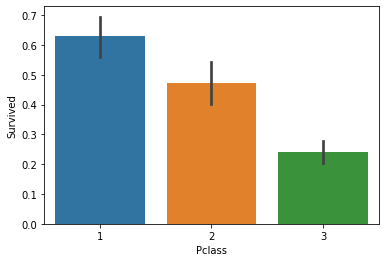

In [7]:
sns.barplot(x="Pclass", y="Survived", data=df_train)

People with ticket of upper classes have higher rate of survival.

**Survival Rate based on sibilings or spouse**


<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

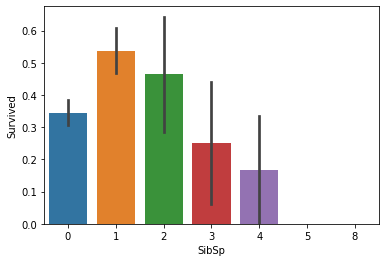

In [8]:
sns.barplot(x="SibSp", y="Survived", data=df_train)

The survival rate is pretty high for people with less sibiling or spouse. We can check if this trend goes on with parent/children.

**Survival Rate based on parent/children**

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

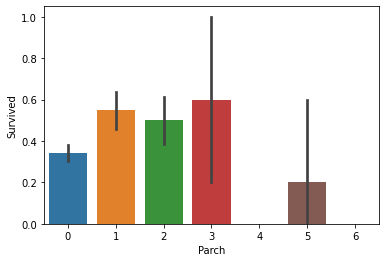

In [9]:
sns.barplot(x="Parch", y="Survived", data=df_train)

Evaluating those plot with the insight of the previous one, we can think that people traveling alone or in large families have lesser chance of survive.

# Handling NaNs

There are some columns with missing value. We need to handle them in order to get the better results from our models.

**Cabin Column**

In [10]:
df['Cabin_Flag'] = df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Flag
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1


In [11]:
df['Cabin'].fillna('Missing',inplace=True)
df['Cabin']=df['Cabin'].astype(str).str[0]
df.Cabin.unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [12]:
mean_ordinals = df.groupby(['Cabin'])['Survived'].mean().sort_values().to_dict()
print(mean_ordinals)
df['Cabin_mean_encode']=df['Cabin'].map(mean_ordinals)

{'T': 0.0, 'M': 0.29985443959243085, 'A': 0.4666666666666667, 'G': 0.5, 'C': 0.5932203389830508, 'F': 0.6153846153846154, 'B': 0.7446808510638298, 'E': 0.75, 'D': 0.7575757575757576}


In [13]:
df_train = df[df['Survived'].notnull()]
df_test = df[df['Survived'].isnull()]

**Embarked Column**

The "Embarked" column has only 2 nans so we can fill them with the most common value


In [14]:
print(df_train['Embarked'].value_counts())

# the most common value is S (for Southampton), so we replace the NaNs with 'S'

df_train = df_train.fillna({"Embarked": "S"})
df_test = df_test.fillna({"Embarked": "S"})

S    644
C    168
Q     77
Name: Embarked, dtype: int64


**Age column**

Since 'Age' has more NaNs, we need to do a bit more of investigation and work there

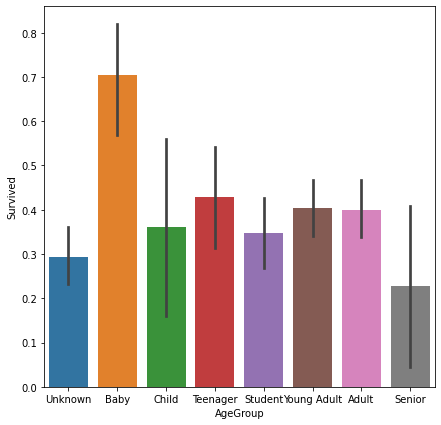

In [15]:
#sort the ages into groups

df_train["Age"] = df_train["Age"].fillna(-0.5)
df_test["Age"] = df_test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
df_train['AgeGroup'] = pd.cut(df_train["Age"], bins, labels = labels)
df_test['AgeGroup'] = pd.cut(df_test["Age"], bins, labels = labels)

#plot the survival rate of every age group
plt.figure(figsize=(7,7))
sns.barplot(x="AgeGroup", y="Survived", data=df_train)
plt.show()

We can see that age as a high impact on survival rate, so it's better to think about the best ways to fill the NaNs in that column.<br>
One thing we can do is extract the title from the name column and assign it to a new column.

In [16]:
df_train['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_train['Title'] = df_train['Title'].replace({"Capt": "Officer",
        "Col": "Officer",
        "Major": "Officer",
        "Jonkheer": "Royalty",
        "Don": "Royalty",
        "Dona": "Royalty",
        "Sir": "Royalty",
        "Dr": "Officer",
        "Rev": "Officer",
        "the Countess": "Royalty",
        "Mme": "Mrs",
        "Mlle": "Miss",
        "Ms": "Mrs",
        "Mr": "Mr",
        "Mrs": "Mrs",
        "Miss": "Miss",
        "Master": "Master",
        "Lady": "Royalty"})

df_test['Title'] = df_test['Title'].replace({"Capt": "Officer",
        "Col": "Officer",
        "Major": "Officer",
        "Jonkheer": "Royalty",
        "Don": "Royalty",
        "Dona": "Royalty",
        "Sir": "Royalty",
        "Dr": "Officer",
        "Rev": "Officer",
        "the Countess": "Royalty",
        "Mme": "Mrs",
        "Mlle": "Miss",
        "Ms": "Mrs",
        "Mr": "Mr",
        "Mrs": "Mrs",
        "Miss": "Miss",
        "Master": "Master",
        "Lady": "Royalty"})

In [17]:
master_ages = list(df_test.loc[df_test['Title'] == 'Master']['Age'])
officer_ages = list(df_test.loc[df_test['Title'] == 'Officer']['Age'])
royalty_ages = list(df_test.loc[df_test['Title'] == 'Royalty']['Age'])
mrs_ages = list(df_test.loc[df_test['Title'] == 'Mrs']['Age'])
miss_ages = list(df_test.loc[df_test['Title'] == 'Miss']['Age'])
mr_ages = list(df_test.loc[df_test['Title'] == 'Mr']['Age'])

print(f'Ages for people sharing Master title: {master_ages}')
print(f'Ages for people sharing Officer title: {officer_ages}')
print(f'Ages for people sharing Royalty title: {royalty_ages}')
print(f'Ages for people sharing Mrs title: {mrs_ages}')
print(f'Ages for people sharing Miss title: {miss_ages}')
print(f'Ages for people sharing Mr title: {mr_ages}')

Ages for people sharing Master title: [9.0, 10.0, 13.0, 6.0, 2.0, 13.0, 7.0, 11.5, 8.0, 6.0, 0.33, -0.5, 0.75, 0.83, -0.5, -0.5, 14.5, 5.0, 6.0, 13.0, -0.5]
Ages for people sharing Officer title: [53.0, 30.0, 41.0, 47.0, 53.0]
Ages for people sharing Royalty title: [39.0]
Ages for people sharing Mrs title: [47.0, 22.0, 18.0, 23.0, 47.0, 24.0, 45.0, -0.5, 48.0, 33.0, -0.5, 30.0, 45.0, 60.0, 36.0, -0.5, 60.0, 55.0, -0.5, 22.0, 27.0, 76.0, 43.0, 16.0, 63.0, 29.0, 35.0, -0.5, 23.0, 36.0, 26.0, 26.0, -0.5, 36.0, 64.0, 18.0, 27.0, -0.5, 60.0, 50.0, 22.0, 53.0, -0.5, 48.0, 55.0, 45.0, 22.0, 29.0, -0.5, 29.0, 26.0, 64.0, 45.0, 55.0, 48.0, 19.0, 58.0, 38.0, 45.0, 59.0, 30.0, 24.0, 31.0, 25.0, -0.5, 45.0, 54.0, -0.5, 19.0, 51.0, 18.0, 48.0, 37.0]
Ages for people sharing Miss title: [30.0, 27.0, 22.0, -0.5, 21.0, 20.0, 28.0, 36.0, 22.0, 18.0, 24.0, 29.0, 35.0, 24.0, 27.0, 18.0, 20.0, -0.5, 36.0, 18.5, 1.0, 12.0, 17.0, -0.5, 23.0, 10.0, 33.0, 29.0, 23.0, -0.5, 26.0, 22.0, 15.0, 20.0, 21.0, -0.5, 1

We can see that people sharing the same title tend to fall into the same age range, so we can fill the NaNs for the ages based on the mean value of the respective title group

In [18]:
df_test.groupby('Title')['Age'].mean().round()

Title
Master      6.0
Miss       18.0
Mr         24.0
Mrs        33.0
Officer    45.0
Royalty    39.0
Name: Age, dtype: float64

In [19]:
df_test.loc[(df_test['Age'] == -0.5) & (df_test['Title']=='Master'),'Age'] = 6
df_test.loc[(df_test['Age'] == -0.5) & (df_test['Title']=='Miss'),'Age'] = 18
df_test.loc[(df_test['Age'] == -0.5) & (df_test['Title']=='Mr'),'Age'] = 24
df_test.loc[(df_test['Age'] == -0.5) & (df_test['Title']=='Mrs'),'Age'] = 33
df_test.loc[(df_test['Age'] == -0.5) & (df_test['Title']=='Officer'),'Age'] = 45
df_test.loc[(df_test['Age'] == -0.5) & (df_test['Title']=='Royalty'),'Age'] = 39

df_train.loc[(df_train['Age'] == -0.5) & (df_train['Title']=='Master'),'Age'] = 6
df_train.loc[(df_train['Age'] == -0.5) & (df_train['Title']=='Miss'),'Age'] = 18
df_train.loc[(df_train['Age'] == -0.5) & (df_train['Title']=='Mr'),'Age'] = 24
df_train.loc[(df_train['Age'] == -0.5) & (df_train['Title']=='Mrs'),'Age'] = 33
df_train.loc[(df_train['Age'] == -0.5) & (df_train['Title']=='Officer'),'Age'] = 45
df_train.loc[(df_train['Age'] == -0.5) & (df_train['Title']=='Royalty'),'Age'] = 39

# Label Encoding

We encode categorical values as numbers to allow our models to work better.

**Encoding Male and Female in Sex column as 0 and 1**

In [20]:
df_train.Sex.replace(to_replace=dict(female=1, male=0), inplace=True)
df_test.Sex.replace(to_replace=dict(female=1, male=0), inplace=True)

**Encoding boarding port in Embarked column as 0, 1, 2**

In [21]:
df_train.Embarked.replace(to_replace=dict(S=0,C=1,Q=2), inplace=True)
df_test.Embarked.replace(to_replace=dict(S=0,C=1,Q=2), inplace=True)

# Feature Choosing

To train a machine learning model we have to choose the most relevant feature in the datasets.

In [22]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Flag,Cabin_mean_encode,AgeGroup,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,M,0,0,0.299854,Student,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,1,1,0.593220,Adult,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,M,0,0,0.299854,Young Adult,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C,0,1,0.593220,Young Adult,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,M,0,0,0.299854,Young Adult,Mr


'Cabin' and 'Cabin_Flag' can be dropped since we summarized them in 'Cabin_mean_encode'.<br>
'Ticket' gives no particular information and can be dropped.<br>
'PassengerID' and 'Name' will have no influence on the prediction and can be dropped.<br>
'AgeGroup' and 'Title' were used to find the missing age values so they can be dropped.<br>
'Survived' is the target of the prediction, so it must be dropped from the features.

In [51]:
X = df_train.drop(['Cabin', 'Cabin_Flag', 'Ticket', 'PassengerId', 'Name', 'Survived', 'AgeGroup', 'Title'], axis=1)
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_mean_encode
0,3,0,22.0,1,0,7.2500,0,0.299854
1,1,1,38.0,1,0,71.2833,1,0.593220
2,3,1,26.0,0,0,7.9250,0,0.299854
3,1,1,35.0,1,0,53.1000,0,0.593220
4,3,0,35.0,0,0,8.0500,0,0.299854
...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,0,0.299854
887,1,1,19.0,0,0,30.0000,0,0.744681
888,3,1,18.0,1,2,23.4500,0,0.299854
889,1,0,26.0,0,0,30.0000,1,0.593220


We can check for correlation between those features

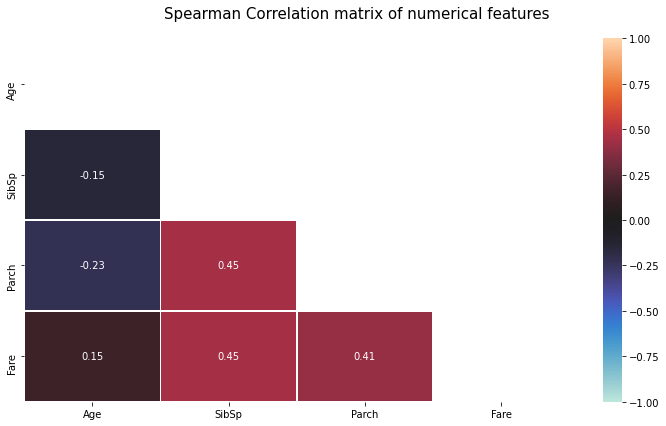

In [28]:
corr = X[['Age','SibSp','Parch','Fare']].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, linewidths=.5, annot=True)

fig.suptitle('Spearman Correlation matrix of numerical features', fontsize=15)
ax.text(0.77, 0.2, '', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()

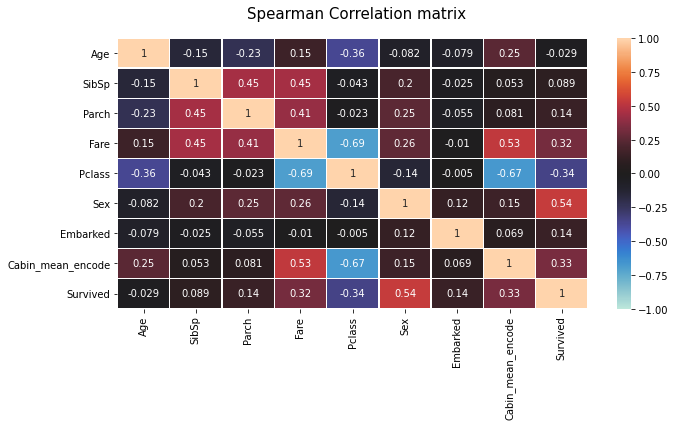

In [35]:
corre = df_train[['Age','SibSp','Parch','Fare', 'Pclass', 'Sex', 'Embarked', 'Cabin_mean_encode', 'Survived']].corr(method='spearman')

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corre, vmin=-1, vmax=1, center=0, linewidths=.5, annot=True)

fig.suptitle('Spearman Correlation matrix', fontsize=15)
ax.text(0.77, 0.2, '', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()


# Models

To test our model before making submission, we define our y as the 'Survived' column of the test dataset and do a split for train/test.

In [52]:
y = df_train['Survived']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

# scaling Xs

from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_mean_encode
0,3,0,22.0,1,0,7.2500,0,0.299854
1,1,1,38.0,1,0,71.2833,1,0.593220
2,3,1,26.0,0,0,7.9250,0,0.299854
3,1,1,35.0,1,0,53.1000,0,0.593220
4,3,0,35.0,0,0,8.0500,0,0.299854
...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,0,0.299854
887,1,1,19.0,0,0,30.0000,0,0.744681
888,3,1,18.0,1,2,23.4500,0,0.299854
889,1,0,26.0,0,0,30.0000,1,0.593220


**Random Forest**

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param = {'n_estimators' : [100, 200, 300, 400, 500],
        'criterion': ['gini', 'entropy'],
        'max_depth': ['None', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_samples_split': [2, 3, 4],
        'bootstrap': ['True', 'False'],
        'random_state': [42, 0, 13]}

forest = RandomForestClassifier()

forest_random = RandomizedSearchCV(forest, param, cv=5)

forest_random.fit(X_train, y_train)

print(f"Best Random Forest Parameters: {forest_random.best_params_}")
print(f"Best score is {forest_random.best_score_}")

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File 

In [63]:
# noticed a NaN in fare, correting it here

df_test['Fare'] = df_test['Fare'].fillna(df_test.Fare.mean())

In [64]:
df_test.isnull().sum()


PassengerId            0
Survived             418
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                  0
Embarked               0
Cabin_Flag             0
Cabin_mean_encode      0
AgeGroup               0
Title                  0
dtype: int64

In [77]:
Xtest = df_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Cabin_mean_encode']]

ytest_pred = forest_random.predict(Xtest)
(ytest_pred)

array([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [80]:
# creating submission file for random forest

ids = df_test['PassengerId']
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': ytest_pred})
output['Survived'] = output['Survived'].astype(int)



output.to_csv('submission.csv', index=False)

**SVC**

In [83]:
from sklearn.svm import SVC

svc = SVC()

params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': list(range(1, 10)),
        'max_iter': [-1],
        'gamma': ['scale', 'auto']}

svc_random = RandomizedSearchCV(svc, params)

svc_random.fit(X_train, y_train)

print(f"Best SVC Parameters: {svc_random.best_params_}")
print(f"Best score is {svc_random.best_score_}")

Best SVC Parameters: {'max_iter': -1, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2}
Best score is 0.8257953314291342


**Gradient Boosting**

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

paramss = {'loss': ['deviance', 'exponential'],
        'n_estimators' : [100, 200, 300, 400, 500],
        'criterion': ['friedman_mse', 'mse', 'mae'],
        'max_depth': ['None', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_samples_split': [2, 3, 4],
        'random_state': [42, 0, 13]}

gbc_random = RandomizedSearchCV(gbc, paramss)

gbc_random.fit(X_train, y_train)

print(f"Best GBC Parameters: {gbc_random.best_params_}")
print(f"Best score is {gbc_random.best_score_}")

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1122: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  "Boosting.", FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1122: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  "Boosting.", FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1122: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boost

**AdaBoost**

In [92]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

paramsss = {'n_estimators' : [50, 100, 200, 300, 400, 500],
            'algorithm': ['SAMME', 'SAMME.R'],
            'random_state': [42, 0, 13]}

ada_random = RandomizedSearchCV(ada, paramsss)

ada_random.fit(X_train, y_train)

print(f"Best AdaBoost Parameters: {ada_random.best_params_}")
print(f"Best score is {ada_random.best_score_}")

Best AdaBoost Parameters: {'random_state': 0, 'n_estimators': 100, 'algorithm': 'SAMME'}
Best score is 0.8047276666994977


**Gaussian Naive Bayes**

In [95]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()

gaussian.fit(X_train, y_train)
gaussian.score(X_train, y_train)

0.7949438202247191